In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [2]:
class Simulation:
    def __init__(self, A, initial_state, whatH):
        self.A = A
        self.initial_state = initial_state
        self.whatH = whatH
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = sc.optimal_omegad(self.A)[0]*2*np.pi

        if self.whatH == 'H2':
            # Setup actual system
            self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 

    def H2(self):
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        # Create H_control with only specific off-diagonal elements
        H_control = self.sc.H_control.copy()
        # Zero out all elements first
        H_control[:] = 0

        # Keep only elements [0,2], [1,3], [2,4], [3,5] and their symmetric counterparts
        for i in range(len(H_control) - 2):
            # Keep the upper diagonal elements [i, i+2]
            H_control[i, i+2] = self.sc.H_control[i, i+2]
            # Make it symmetric by setting [i+2, i]
            H_control[i+2, i] = self.sc.H_control[i+2, i]

        H0 = qt.Qobj(H0) 
        H_control = qt.Qobj(H_control)
        H_rot = self.optimal_omega*np.kron(np.array([[0,0,0],[0,1,0],[0,0,2]]), np.identity(2)) + self.optimal_omega*np.kron(np.identity(3), np.array([[0,0],[0,1]])) 

        # H_rot = H0 + A/2*H_control
        H0_rot = H0.full() - H_rot+ self.A/2 * H_control.full()
        evals_rot, U = np.linalg.eigh(H0_rot)
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        evals_rot = evals_rot - evals_rot[0]
        self.omega_c = evals_rot[1]
        H0 = np.diag(evals_rot)
        H0 = qt.Qobj(H0)

        Ud = U.T.conj()
        U = qt.Qobj(U)
        Ud = qt.Qobj(Ud)
        dressed00 = qt.basis(6,0)
        dressed01 = qt.basis(6,1)
        dressed10 = qt.basis(6,2)
        dressed11 = qt.basis(6,3)
        P10 = dressed10 * dressed10.dag()
        P11 = dressed11 * dressed11.dag()
        P00 = dressed00 * dressed00.dag()
        P01 = dressed01 * dressed01.dag()
        sigmaxc = qt.Qobj(np.kron(np.identity(3), np.array([[0,1],[1,0]])))
        sigmaxs = qt.Qobj(np.kron(np.array([[0,1,0],[1,0,0],[0,0,0]]), np.identity(2)))
        initial00 = dressed00
        initial01 = dressed01
        initialpc = np.sqrt(1/2)*(dressed00 + dressed01)
        initialps = np.sqrt(1/2)*(dressed00 + dressed10)
        noise = Ud@np.diag(np.diag(self.sc.noise) - np.diag(self.sc.noise)[0])@U
        self.s = np.zeros([6,6], dtype=complex)
        self.s[:4,:4] = self.sc.s[:4,:4]
        self.s = Ud@self.s@U
        
        self.s = self.s.full()
        for i in range(1,4):
            self.s[i,i] = self.s[i,i] - self.s[0,0]
        self.s[0,0] = 0
        self.s = qt.Qobj(self.s)
        noise = qt.Qobj(noise)
        if self.initial_state == '00':
            initial_state = initial00
            M = P10
        elif self.initial_state == '01':
            initial_state = initial01
            M = [P00,P01,P10,P11]
        elif self.initial_state == 'pc':
            initial_state = initialpc
            M = sigmaxc
        elif self.initial_state == 'ps':
            initial_state = initialps
            M = sigmaxs
        
        return H0,initial_state, M, noise
  
    def gaussian_ramp(self, t_rise, t_flat, t_down, amplitude):
        """
        Creates a time-dependent function using a Gaussian function that rises, 
        stays flat, and then falls.

        Args:
        t_rise (float): The time at which the function reaches the amplitude.
        t_flat (float): The duration for which the function stays at the amplitude.
        t_down (float): The time it takes for the function to fall back to zero.
        amplitude (float): The maximum amplitude of the Gaussian peak.

        Returns:
        function: A function of time 't' that implements the desired behavior.
        """
        # Define the standard deviation for the Gaussian edges
        sigma_rise = t_rise / 3  # Adjust sigma to make the function start close to zero at t=0
        sigma_down = t_down / 3  # Similar adjustment for the falling edge

        # Define the function using a closure to encapsulate the parameters
        def time_dependent_function(t):
            t_start_flat = t_rise  # Time when flat region starts
            t_end_flat = t_rise + t_flat  # Time when flat region ends
            
            if t <= t_start_flat:
                # Gaussian rise centered at t_rise
                return amplitude * np.exp(-((t - t_start_flat)**2) / (2 * sigma_rise**2)) - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))
            elif t >= t_end_flat:
                # Gaussian fall centered at t_end_flat
                return amplitude * np.exp(-((t - t_end_flat)**2) / (2 * sigma_down**2)) - amplitude * np.exp(-((t_end_flat + t_down - t_end_flat)**2) / (2 * sigma_down**2))
            else:
                # Constant amplitude in the middle region
                return amplitude - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))

        return time_dependent_function

In [3]:
def filter_matrix_elements(matrix, indices):
    """
    Filter a matrix to keep only specified matrix elements, setting all others to zero.
    
    Args:
        matrix: Input matrix (numpy array or qutip Qobj)
        indices: List of [row, col] pairs specifying which elements to keep
                Example: [[0,0], [0,1]] keeps only elements (0,0) and (0,1)
    
    Returns:
        Filtered matrix with same type as input
    """
    # Handle qutip Qobj
    if hasattr(matrix, 'data'):
        # Create a copy of the matrix data - handle both sparse and dense formats
        if hasattr(matrix.data, 'toarray'):
            # Sparse matrix
            filtered_data = np.zeros_like(matrix.data.toarray())
        else:
            # Dense matrix or memoryview - convert to numpy array
            filtered_data = np.zeros_like(np.array(matrix.data))
        
        # Keep only specified elements
        for row, col in indices:
            if row < matrix.shape[0] and col < matrix.shape[1]:
                if hasattr(matrix.data, 'toarray'):
                    filtered_data[row, col] = matrix.data.toarray()[row, col]
                else:
                    filtered_data[row, col] = np.array(matrix.data)[row, col]
        
        # Return as qutip Qobj with same properties
        return qt.Qobj(filtered_data)
    
    # Handle numpy arrays
    else:
        filtered_matrix = np.zeros_like(matrix)
        
        # Keep only specified elements
        for row, col in indices:
            if row < matrix.shape[0] and col < matrix.shape[1]:
                filtered_matrix[row, col] = matrix[row, col]
        
        return filtered_matrix


In [16]:
def simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type):
    """
    Simulate dephasing due to colored noise for given parameters.
    
    Parameters:
    -----------
    A : float
        Coupling strength
    S0 : float
        Noise amplitude
    t_max : int
        Maximum time in ns
    num_realizations : int
        Number of noise realizations
    
    Returns:
    --------
    tuple
        (time_points, result) where result is array of shape (num_realizations, N)
    """
    N = t_max
    time_points = np.linspace(0, t_max, N)
    sample_rate = 1        # per ns
    tnoise_max = int(1e6)             # number of samples
    relative_PSD_strength = S0**2
    ifwhite = False               # True for white noise, False for 1/f noise
    
    gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)
    trajs = gn.generate_colored_noise()
    S0 = gn.analyze_noise_psd(trajs, ifplot=False)
    
    
    # Define parameter ranges
    options = {'rtol': 1e-10, 'atol': 1e-10}
    # T1 measurement (01 -> 00 decay)
    initial_state_type = '00'
    whatH = 'H2'
    simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
    H0, initial_state, M, noise = simulation.H2()
    # Define the indices for the desired subspace (0 and 2)
    # subspace_indices = [0, 2]

    # # Extract the 2x2 submatrix from H0 and noise by selecting only rows and columns 0 and 2
    # H0_sub = qt.Qobj(H0.full()[np.ix_(subspace_indices, subspace_indices)], dims=[[2], [2]])
    # noise_sub = qt.Qobj(noise.full()[np.ix_(subspace_indices, subspace_indices)], dims=[[2], [2]])
    # M_sub = qt.Qobj(M.full()[np.ix_(subspace_indices, subspace_indices)], dims=[[2], [2]])
    # # Reassign the filtered Qobj to H0 and noise for further use
    # H0, noise, M = H0_sub, noise_sub, M_sub   
    # initial_state = qt.basis(2, 0)

    def simulate_trajectory(i):
        # Create Hamiltonian with increased nsteps for better integration
        traj = np.cos(simulation.phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(simulation.phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
        H = [H0 , [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
        
        # Use options to increase nsteps and improve integration stability
        opts = {'nsteps': t_max, 'atol': 1e-10, 'rtol': 1e-10}
        result = qt.sesolve(H, initial_state, time_points, options=opts)
        avg_values = np.zeros(len(time_points))
        
        for j, t in enumerate(time_points):
            state_t = result.states[j]
            avg_values[j] = qt.expect(M, state_t) 
        return avg_values

    result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

    # Convert to numpy array for easier analysis
    result = np.array(result)
    return time_points, simulation, result, S0



In [21]:

# Example usage with specific parameters
initial_state_type = '00'
A = 1e-3 * 2 * np.pi
S0 = 1e-5
t_max =10000
num_realizations = 1000
time_poiqnts, simulation, result, S0_used = simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type)
avg_values = np.mean(result, axis=0)

time_points, simulation, result, S0 = simulate_colored_noise_dephasing(A, S0, t_max, num_realizations, initial_state_type)

In [24]:
def analyze_and_fit_decay(simulation, time_points, avg_value, S0, ifplot=True):
    from scipy.optimize import curve_fit
    # Setup time points
    t_max = time_points[-1]
    N = t_max
    if simulation.initial_state == '00' or simulation.initial_state == '01':
        # Define exponential decay function with fixed offset of 1/2
        def exp_decay_fixed_offset(t, T):
            return 0.5 * (1 - np.exp(-t / T))
    # Fit the data with exponential decay (fixed offset = 1/2)
    params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_value, p0=[1000])
    T_fit = params[0]

    if ifplot:
        # Plot the results with the fit
        plt.figure(figsize=(5, 3))
        # std_value = np.std(result, axis=0)
        # plt.errorbar(time_points, avg_value, yerr=std_value, fmt='b-', label='Simulation data', capsize=3)
        plt.plot(time_points, avg_value, 'b-', label='Simulation data')
        plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
                    label=f'Fit: 0.5*(1+exp(-t/T)), T = {T_fit:.2f} ns')
        plt.xlabel('Time (ns)')
        plt.ylabel('Population')
        plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print the fitted parameters
    if ifplot:
        print(f"Fitted T = {T_fit:.4f} ns")
    sc = simulation.sc
    S0P = S0 * (sc.omega_s_per - sc.omega_s) / 1e-6
    optimal_omega = simulation.optimal_omega
    sc = Hamiltonian(sc.phi_ex, sc.Ej, sc.Ec, [2,1])
    H0, initial_state, M, noise = simulation.H2()
    evals_rot, U = np.linalg.eigh((H0).full())
    evals_rot, U = sort_eigenpairs(evals_rot, U)
    Ud = U.T.conj()
    me = (Ud@noise.full()@U)[0,2]
    detu = (evals_rot[2]-evals_rot[0])/2/np.pi
    rate = S0**2 / (detu) * (np.abs(me)*np.pi*np.sin(0.2*np.pi))**2 * 2
    estimated_time = 1 / rate
    if ifplot:
        print(f"Estimated T = {estimated_time:.4f} ns")
    analytical_T2 = 1/(2*S0P**2/0.1/4)
    if ifplot:
        print(f"Analytical T2 = {analytical_T2:.4f} ns")
    
    return T_fit, estimated_time, analytical_T2

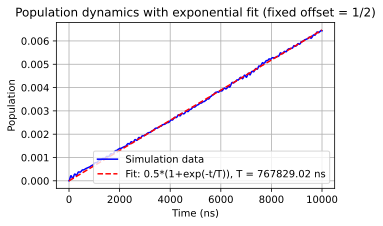

Fitted T = 767829.0218 ns
Estimated T = -803878.1184 ns
Analytical T2 = 983702.5918 ns


(np.float64(767829.0218366226),
 np.float64(-803878.1184355328),
 np.float64(983702.5917989213))

In [25]:
avg_values = np.mean(result, axis=0)
analyze_and_fit_decay(simulation, time_points, avg_values, S0)